## ⚙️ Configuration & Hyperparameters

Set all hyperparameters and configuration options in one place for easy tuning.

In [1]:
# =============================================================================
# HYPERPARAMETERS CONFIGURATION
# =============================================================================

# Text2Graph Parameters
WINDOW_SIZE = 3                    # Co-occurrence window size for graph construction
MIN_FREQUENCY = 1                  # Minimum word frequency threshold (set to 1 for demo)
WEIGHT_METHOD = "frequency"        # Edge weight method: "frequency" or "pmi"

# Random Walk Parameters  
WALK_LENGTH = 10                   # Maximum length of each random walk
NUM_WALKS_PER_NODE = 5             # Number of walks to generate from each node

# Skip-gram (Word2Vec) Parameters
VECTOR_SIZE = 128                  # Embedding dimension
CONTEXT_WINDOW = 5                 # Context window size for Skip-gram
MIN_COUNT = 1                      # Minimum word count for vocabulary (set to 1 for demo)
NEGATIVE_SAMPLES = 15              # Number of negative samples
EPOCHS = 20                        # Training epochs
LEARNING_RATE = 0.025             # Initial learning rate
WORKERS = 4                       # Number of worker threads

# Visualization Parameters
TOP_WORDS_TSNE = 50               # Number of top words for t-SNE visualization
N_CLUSTERS = 5                    # Number of clusters for K-means
TSNE_PERPLEXITY = 30              # t-SNE perplexity parameter

# Random Seeds for Reproducibility
RANDOM_SEED = 42

print("✅ Configuration loaded successfully!")
print(f"📊 Key parameters: Vector Size={VECTOR_SIZE}, Walk Length={WALK_LENGTH}, Epochs={EPOCHS}, MinFreq={MIN_FREQUENCY}, MinCount={MIN_COUNT}")

✅ Configuration loaded successfully!
📊 Key parameters: Vector Size=128, Walk Length=10, Epochs=20, MinFreq=1, MinCount=1


# 🚀 DeepWalk: Graph Embedding Pipeline

Notebook tổng hợp toàn bộ quy trình từ **text → graph → random walks → embeddings**

## 📋 Quy trình:
1. **Text2Graph**: Chuyển văn bản tiếng Việt thành đồ thị co-occurrence
2. **Random Walk**: Tạo sequences từ đồ thị
3. **Skip-gram Training**: Huấn luyện Word2Vec trên walks
4. **Embedding Analysis**: Phân tích và trực quan hóa kết quả
5. **Export Results**: Lưu embeddings và model

## 🔧 Import Libraries và Setup

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# Graph processing
import networkx as nx
from collections import defaultdict, Counter

# NLP processing
try:
    from underthesea import word_tokenize
    print("✅ underthesea imported successfully")
except ImportError:
    print("❌ underthesea not found. Install: pip install underthesea")

# Machine Learning
try:
    from gensim.models import Word2Vec
    from sklearn.manifold import TSNE
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.cluster import KMeans
    print("✅ ML libraries imported successfully")
except ImportError:
    print("❌ Missing libraries. Install: pip install gensim scikit-learn")

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("🎯 Setup complete!")

✅ underthesea imported successfully
✅ ML libraries imported successfully
🎯 Setup complete!
✅ ML libraries imported successfully
🎯 Setup complete!


## 📂 Load Data

In [3]:
# Load text files from data directory
data_dir = Path("data")
text_files = list(data_dir.glob("*.txt"))

print(f"📂 Found {len(text_files)} text files:")
for file in text_files:
    print(f"  - {file.name}")

# Read and combine all texts
all_text = ""
for file in text_files:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read().strip()
        all_text += content + " "
        print(f"📄 {file.name}: {len(content)} characters")

print(f"\n📊 Total text length: {len(all_text)} characters")
print(f"📝 Preview: {all_text[:200]}...")

📂 Found 10 text files:
  - 10.txt
  - 9.txt
  - 8.txt
  - 5.txt
  - 4.txt
  - 6.txt
  - 7.txt
  - 3.txt
  - 2.txt
  - 1.txt
📄 10.txt: 2006 characters
📄 9.txt: 1973 characters
📄 8.txt: 2013 characters
📄 5.txt: 1429 characters
📄 4.txt: 1094 characters
📄 6.txt: 1898 characters
📄 7.txt: 1795 characters
📄 3.txt: 1155 characters
📄 2.txt: 1152 characters
📄 1.txt: 1194 characters

📊 Total text length: 15719 characters
📝 Preview: Đại Tây Dương là đại dương lớn thứ hai trên Trái Đất, chỉ sau Thái Bình Dương, với diện tích khoảng 106 triệu km², chiếm gần 20% diện tích bề mặt hành tinh. Nằm giữa châu Âu và châu Phi ở phía đông và...


## 🏗️ Step 1: Text2Graph - Build Co-occurrence Graph

In [4]:
class TextGraphBuilder:
    """
    Build co-occurrence graph from Vietnamese text
    """
    def __init__(self, window_size=WINDOW_SIZE, weight_method=WEIGHT_METHOD):
        self.window_size = window_size
        self.weight_method = weight_method
        self.cooccurrence_matrix = defaultdict(lambda: defaultdict(int))
        self.word_counts = defaultdict(int)
        
    def process_text(self, text):
        """Tokenize and clean Vietnamese text (keep all tokens for tiny demo)"""
        # Tokenize with underthesea
        tokens = word_tokenize(text)
        
        # Minimal normalization: lower-case, strip spaces; keep underscores and short tokens
        cleaned_tokens = []
        for token in tokens:
            t = token.strip().lower()
            if t:  # keep anything non-empty
                cleaned_tokens.append(t)
                
        print(f"📝 Tokens: {len(tokens)} → Cleaned: {len(cleaned_tokens)} (no filtering)")
        return cleaned_tokens
    
    def build_cooccurrence_matrix(self, tokens):
        """Build co-occurrence matrix with sliding window"""
        for i, center_word in enumerate(tokens):
            self.word_counts[center_word] += 1
            
            # Sliding window
            start = max(0, i - self.window_size)
            end = min(len(tokens), i + self.window_size + 1)
            
            for j in range(start, end):
                if i != j:
                    context_word = tokens[j]
                    self.cooccurrence_matrix[center_word][context_word] += 1
                    
        print(f"🔗 Co-occurrence matrix built: {len(self.cooccurrence_matrix)} words")
        
    def calculate_pmi(self, word1, word2, total_words):
        """Calculate Pointwise Mutual Information"""
        if word1 not in self.word_counts or word2 not in self.word_counts:
            return 0
            
        p_word1 = self.word_counts[word1] / total_words
        p_word2 = self.word_counts[word2] / total_words
        p_cooccur = self.cooccurrence_matrix[word1][word2] / total_words
        
        if p_cooccur == 0:
            return 0
            
        pmi = np.log(p_cooccur / (p_word1 * p_word2))
        return max(0, pmi)  # Positive PMI
    
    def build_graph(self, min_frequency=MIN_FREQUENCY):
        """Create NetworkX graph from co-occurrence matrix"""
        G = nx.Graph()
        total_words = sum(self.word_counts.values())
        
        # Filter words by minimum frequency (set to 1 for demo: keep all)
        frequent_words = {
            word: count for word, count in self.word_counts.items() 
            if count >= min_frequency
        }
        
        print(f"📊 Filtering: {len(self.word_counts)} → {len(frequent_words)} words (min_freq={min_frequency})")
        
        # Add nodes
        for word, count in frequent_words.items():
            G.add_node(word, frequency=count)
            
        # Add edges with weights
        edge_count = 0
        for word1 in frequent_words:
            for word2, cooccur_count in self.cooccurrence_matrix[word1].items():
                if word2 in frequent_words and word1 < word2:  # Avoid duplicate edges
                    if self.weight_method == "frequency":
                        weight = cooccur_count
                    elif self.weight_method == "pmi":
                        weight = self.calculate_pmi(word1, word2, total_words)
                    else:
                        weight = 1
                        
                    if weight > 0:
                        G.add_edge(word1, word2, weight=weight)
                        edge_count += 1
                        
        print(f"🔗 Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        return G

# Initialize graph builder
graph_builder = TextGraphBuilder()
print("🏗️ TextGraphBuilder initialized")

🏗️ TextGraphBuilder initialized


In [5]:
# Build graph from text
print("🔄 Processing text...")
tokens = graph_builder.process_text(all_text)

print("\n🔄 Building co-occurrence matrix...")
graph_builder.build_cooccurrence_matrix(tokens)

print("\n🔄 Creating graph...")
G = graph_builder.build_graph()

# Graph statistics
print(f"\n📊 Graph Statistics:")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")
print(f"  - Density: {nx.density(G):.4f}")
print(f"  - Connected components: {nx.number_connected_components(G)}")

if G.number_of_nodes() > 0:
    # Get largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_main = G.subgraph(largest_cc).copy()
    print(f"  - Largest component: {G_main.number_of_nodes()} nodes, {G_main.number_of_edges()} edges")
    
    # Top nodes by frequency
    node_frequencies = [(node, data['frequency']) for node, data in G.nodes(data=True)]
    top_nodes = sorted(node_frequencies, key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\n🔝 Top 10 frequent words:")
    for word, freq in top_nodes:
        print(f"  - {word}: {freq}")
else:
    print("❌ Empty graph! Try lowering min_frequency")

🔄 Processing text...
📝 Tokens: 2780 → Cleaned: 2780 (no filtering)

🔄 Building co-occurrence matrix...
🔗 Co-occurrence matrix built: 769 words

🔄 Creating graph...
📊 Filtering: 769 → 769 words (min_freq=1)
🔗 Graph created: 769 nodes, 5826 edges

📊 Graph Statistics:
  - Nodes: 769
  - Edges: 5826
  - Density: 0.0197
  - Connected components: 1
  - Largest component: 769 nodes, 5826 edges

🔝 Top 10 frequent words:
  - ,: 230
  - và: 100
  - .: 96
  - là: 67
  - của: 60
  - với: 36
  - núi: 27
  - đến: 24
  - những: 24
  - đại dương: 22
📝 Tokens: 2780 → Cleaned: 2780 (no filtering)

🔄 Building co-occurrence matrix...
🔗 Co-occurrence matrix built: 769 words

🔄 Creating graph...
📊 Filtering: 769 → 769 words (min_freq=1)
🔗 Graph created: 769 nodes, 5826 edges

📊 Graph Statistics:
  - Nodes: 769
  - Edges: 5826
  - Density: 0.0197
  - Connected components: 1
  - Largest component: 769 nodes, 5826 edges

🔝 Top 10 frequent words:
  - ,: 230
  - và: 100
  - .: 96
  - là: 67
  - của: 60
  - với: 

## 🚶 Step 2: Random Walk Generation

In [6]:
class RandomWalker:
    """
    Generate random walk sequences from graph
    """
    def __init__(self, graph, walk_length=WALK_LENGTH, num_walks_per_node=NUM_WALKS_PER_NODE):
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks_per_node = num_walks_per_node
        
    def single_walk(self, start_node):
        """Perform a single random walk from starting node"""
        if start_node not in self.graph:
            return [start_node]
            
        walk = [start_node]
        current_node = start_node
        
        for _ in range(self.walk_length - 1):
            neighbors = list(self.graph.neighbors(current_node))
            if not neighbors:
                break
                
            # Uniform random selection
            next_node = random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node
            
        return walk
    
    def generate_walks(self, nodes=None):
        """Generate multiple walks from all nodes"""
        if nodes is None:
            nodes = list(self.graph.nodes())
            
        all_walks = []
        
        for node in nodes:
            for _ in range(self.num_walks_per_node):
                walk = self.single_walk(node)
                if len(walk) > 1:  # Keep walks with at least 2 nodes
                    all_walks.append(walk)
                    
        print(f"🚶 Generated {len(all_walks)} walks from {len(nodes)} nodes")
        return all_walks
    
    def analyze_walks(self, walks):
        """Analyze walk statistics"""
        if not walks:
            return
            
        walk_lengths = [len(walk) for walk in walks]
        all_nodes_in_walks = [node for walk in walks for node in walk]
        node_coverage = len(set(all_nodes_in_walks))
        
        print(f"\n📊 Walk Analysis:")
        print(f"  - Total walks: {len(walks)}")
        print(f"  - Node coverage: {node_coverage}/{self.graph.number_of_nodes()} ({node_coverage/self.graph.number_of_nodes()*100:.1f}%)")
        print(f"  - Total walk steps: {len(all_nodes_in_walks)}")
        
        return {
            'num_walks': len(walks),
            'node_coverage': node_coverage,
            'total_steps': len(all_nodes_in_walks)
        }

# Initialize random walker
walker = RandomWalker(G_main)
print("🚶 RandomWalker initialized")

🚶 RandomWalker initialized


In [7]:
# Generate random walks
print("🔄 Generating random walks...")
walks = walker.generate_walks()

# Analyze walks
walk_stats = walker.analyze_walks(walks)

# Show sample walks
print(f"\n🎯 Sample walks:")
for i, walk in enumerate(walks[:5]):
    walk_str = " → ".join(walk)
    print(f"  Walk {i+1}: {walk_str}")

if len(walks) > 5:
    print(f"  ... and {len(walks)-5} more walks")

🔄 Generating random walks...
🚶 Generated 3845 walks from 769 nodes

📊 Walk Analysis:
  - Total walks: 3845
  - Node coverage: 769/769 (100.0%)
  - Total walk steps: 38450

🎯 Sample walks:
  Walk 1: đại tây dương → : → đại dương → – → 165 → , → không chỉ → nhau → nối tiếp → như
  Walk 2: đại tây dương → vượt → , → khang su văn → sẽ → , → km² → khoảng → thế giới → của
  Walk 3: đại tây dương → gama → đã → là → không chỉ → núi → chinh phục → chiêm ngưỡng → người → đặt chân
  Walk 4: đại tây dương → ngày nay → hệ thống → chùa tháp → , → bắc cực → vùng → cá → không chỉ → máy bay
  Walk 5: đại tây dương → và → qua → đưa → , → địa chất → khu vực → và → tôn trọng → –
  ... and 3840 more walks


## 🧠 Step 3: Skip-gram Training (Word2Vec)

In [8]:
class DeepWalkEmbedding:
    """
    DeepWalk implementation using Skip-gram (Word2Vec) on random walks
    """
    def __init__(self, vector_size=VECTOR_SIZE, window=CONTEXT_WINDOW, min_count=MIN_COUNT, 
                 negative=NEGATIVE_SAMPLES, epochs=EPOCHS, alpha=LEARNING_RATE, workers=WORKERS):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.negative = negative
        self.epochs = epochs
        self.alpha = alpha
        self.workers = workers
        self.model = None
        
    def train_on_walks(self, walks):
        """Train Skip-gram model on random walks"""
        print(f"🧠 Training Skip-gram model...")
        print(f"  - Vector size: {self.vector_size}")
        print(f"  - Window size: {self.window}")
        print(f"  - Negative sampling: {self.negative}")
        print(f"  - Epochs: {self.epochs}")
        
        # Convert walks to sentences for Word2Vec
        sentences = [walk for walk in walks if len(walk) > 1]
        
        # Initialize and train Word2Vec model
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=1,  # Skip-gram
            negative=self.negative,
            epochs=self.epochs,
            alpha=self.alpha,
            workers=self.workers,
            seed=RANDOM_SEED
        )
        
        print(f"✅ Training completed!")
        print(f"  - Vocabulary size: {len(self.model.wv.key_to_index)}")
        print(f"  - Vector size: {self.model.wv.vector_size}")
        
        return self.model
    
    def get_embeddings(self):
        """Get embeddings matrix"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
            
        words = list(self.model.wv.key_to_index.keys())
        embeddings = np.array([self.model.wv[word] for word in words])
        
        return words, embeddings
    
    def get_similarity(self, word1, word2):
        """Calculate similarity between two words"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
            
        try:
            return self.model.wv.similarity(word1, word2)
        except KeyError as e:
            print(f"Word not in vocabulary: {e}")
            return 0.0
    
    def find_similar_words(self, word, topn=5):
        """Find similar words"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
            
        try:
            return self.model.wv.most_similar(word, topn=topn)
        except KeyError as e:
            print(f"Word not in vocabulary: {e}")
            return []

# Initialize DeepWalk model
deepwalk = DeepWalkEmbedding()
print("🧠 DeepWalkEmbedding initialized")

🧠 DeepWalkEmbedding initialized


In [9]:
# Train the model
if len(walks) > 0:
    print("🔄 Training DeepWalk model...")
    model = deepwalk.train_on_walks(walks)
    
    # Get embeddings
    words, embeddings = deepwalk.get_embeddings()
    print(f"\n📊 Embeddings shape: {embeddings.shape}")
    print(f"📝 Sample words: {words[:10]}")
    
else:
    print("❌ No walks generated! Cannot train model.")

🔄 Training DeepWalk model...
🧠 Training Skip-gram model...
  - Vector size: 128
  - Window size: 5
  - Negative sampling: 15
  - Epochs: 20
✅ Training completed!
  - Vocabulary size: 769
  - Vector size: 128

📊 Embeddings shape: (769, 128)
📝 Sample words: [',', 'và', '.', 'là', 'của', 'với', 'những', '–', 'đến', 'đại dương']
✅ Training completed!
  - Vocabulary size: 769
  - Vector size: 128

📊 Embeddings shape: (769, 128)
📝 Sample words: [',', 'và', '.', 'là', 'của', 'với', 'những', '–', 'đến', 'đại dương']


In [10]:
# Debug: Check vocabulary and model status
if deepwalk.model is not None:
    print("🔍 Vocabulary Debug Information")
    vocabulary = list(deepwalk.model.wv.key_to_index.keys())
    
    print(f"📊 Model Statistics:")
    print(f"  - Vocabulary size: {len(vocabulary)}")
    print(f"  - Embedding dimensions: {deepwalk.model.wv.vector_size}")
    print(f"  - Total walks used: {len(walks)}")
    
    print(f"\n📝 Sample vocabulary (first 20 words):")
    for i, word in enumerate(vocabulary[:20]):
        print(f"  {i+1:2d}. {word}")
    
    if len(vocabulary) > 20:
        print(f"  ... and {len(vocabulary)-20} more words")
        
    # Check if common test words exist
    test_words = ["học", "sinh", "trường", "giáo viên", "đại học", "học sinh"]
    print(f"\n🎯 Test words availability:")
    for word in test_words:
        status = "✅" if word in vocabulary else "❌"
        print(f"  {status} {word}")
        
else:
    print("❌ Model not trained - check previous steps")

🔍 Vocabulary Debug Information
📊 Model Statistics:
  - Vocabulary size: 769
  - Embedding dimensions: 128
  - Total walks used: 3845

📝 Sample vocabulary (first 20 words):
   1. ,
   2. và
   3. .
   4. là
   5. của
   6. với
   7. những
   8. –
   9. đến
  10. đại dương
  11. nhiều
  12. núi
  13. như
  14. giữa
  15. trong
  16. các
  17. nơi
  18. được
  19. trên
  20. biển
  ... and 749 more words

🎯 Test words availability:
  ❌ học
  ❌ sinh
  ❌ trường
  ❌ giáo viên
  ❌ đại học
  ❌ học sinh


## 📊 Step 4: Embedding Analysis

In [11]:
# Word similarity analysis
if deepwalk.model is not None:
    print("🔍 Word Similarity Analysis")
    
    # Get vocabulary from trained model
    vocabulary = set(deepwalk.model.wv.key_to_index.keys())
    print(f"📚 Vocabulary size: {len(vocabulary)}")
    print(f"📝 Sample vocabulary: {list(vocabulary)[:10]}")
    
    # Test some word pairs - only use words that are in vocabulary
    test_pairs = [
        ("học", "sinh"),
        ("trường", "đại học"),
        ("giáo viên", "học sinh"),
        ("toán", "học"),
        ("sách", "đọc")
    ]
    
    print("\n🔗 Word pair similarities:")
    found_pairs = 0
    for word1, word2 in test_pairs:
        if word1 in vocabulary and word2 in vocabulary:
            similarity = deepwalk.get_similarity(word1, word2)
            print(f"  - {word1} ↔ {word2}: {similarity:.3f}")
            found_pairs += 1
        else:
            missing = []
            if word1 not in vocabulary:
                missing.append(word1)
            if word2 not in vocabulary:
                missing.append(word2)
            print(f"  - {word1} ↔ {word2}: Missing words: {missing}")
    
    if found_pairs == 0:
        print("  ⚠️ No test word pairs found in vocabulary")
    
    # Find similar words - use words from actual vocabulary
    test_words = ["học", "sinh", "trường", "giáo viên"]
    available_test_words = [word for word in test_words if word in vocabulary]
    
    # If no predefined test words available, use some from vocabulary
    if not available_test_words:
        available_test_words = list(vocabulary)[:4]
    
    print(f"\n🎯 Most similar words (testing with: {available_test_words}):")
    for word in available_test_words:
        similar_words = deepwalk.find_similar_words(word, topn=3)
        if similar_words:
            similar_str = ", ".join([f"{w}({s:.3f})" for w, s in similar_words])
            print(f"  - {word}: {similar_str}")
        else:
            print(f"  - {word}: No similar words found")
            
else:
    print("❌ Model not available for similarity analysis")

🔍 Word Similarity Analysis
📚 Vocabulary size: 769
📝 Sample vocabulary: ['kết nối', 'nhà', 'tách', 'hoang sơ', 'ngoài ra', 'biên viễn', 'đậm chất', 'nổi bật', 'quyền', 'hòa quyện']

🔗 Word pair similarities:
  - học ↔ sinh: Missing words: ['học', 'sinh']
  - trường ↔ đại học: Missing words: ['trường', 'đại học']
  - giáo viên ↔ học sinh: Missing words: ['giáo viên', 'học sinh']
  - toán ↔ học: Missing words: ['toán', 'học']
  - sách ↔ đọc: Missing words: ['sách', 'đọc']
  ⚠️ No test word pairs found in vocabulary

🎯 Most similar words (testing with: ['kết nối', 'nhà', 'tách', 'hoang sơ']):
  - kết nối: nền(0.701), trái tim(0.644), cây(0.618)
  - nhà: biên cương(0.809), nóc(0.790), do(0.779)
  - tách: mảng(0.869), kiến tạo(0.854), dần(0.806)
  - hoang sơ: nét(0.653), thơ mộng(0.636), đẹp(0.602)


🎨 Creating t-SNE visualization...
📊 Visualizing 50 most frequent words


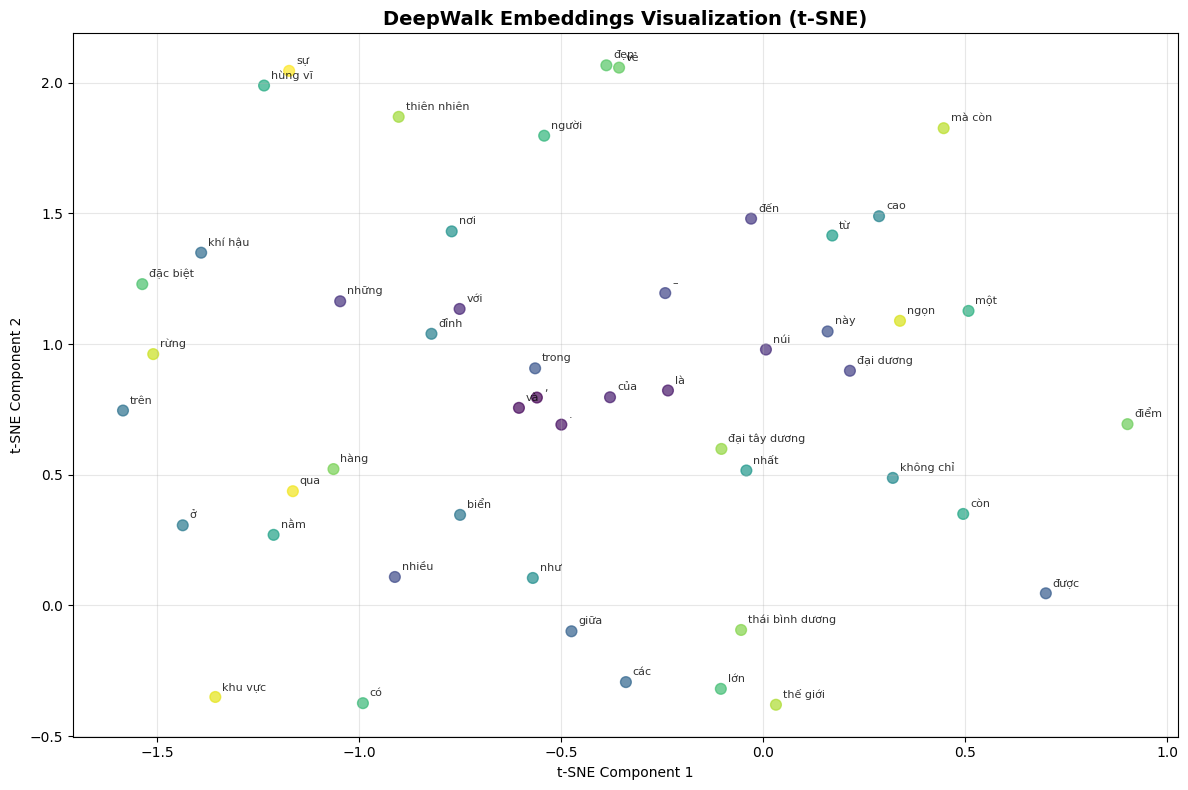

✅ Visualization completed!


In [12]:
# t-SNE visualization
if deepwalk.model is not None and len(words) > 10:
    print("🎨 Creating t-SNE visualization...")
    
    # Select words that are both in graph and model vocabulary
    vocabulary = set(deepwalk.model.wv.key_to_index.keys())
    available_words = [word for word in words if word in vocabulary and word in G.nodes]
    
    if len(available_words) < 5:
        print(f"⚠️ Only {len(available_words)} words available for visualization (need at least 5)")
        print(f"Available words: {available_words}")
    else:
        # Get frequency information for available words
        word_freq = [(word, G.nodes[word]['frequency']) for word in available_words]
        word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)
        
        # Take top words for cleaner visualization
        num_words_to_show = min(TOP_WORDS_TSNE, len(word_freq_sorted))
        top_words = [word for word, freq in word_freq_sorted[:num_words_to_show]]
        top_embeddings = np.array([deepwalk.model.wv[word] for word in top_words])
        
        print(f"📊 Visualizing {len(top_words)} most frequent words")
        
        # Apply t-SNE
        perplexity = min(TSNE_PERPLEXITY, len(top_words)-1)
        tsne = TSNE(n_components=2, perplexity=perplexity, 
                    random_state=RANDOM_SEED, max_iter=1000)
        embeddings_2d = tsne.fit_transform(top_embeddings)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                             alpha=0.7, s=60, c=range(len(top_words)), cmap='viridis')
        
        # Add word labels
        for i, word in enumerate(top_words):
            plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.8)
        
        plt.title('DeepWalk Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("✅ Visualization completed!")
        
elif deepwalk.model is not None:
    print("⚠️ Cannot create visualization: insufficient data (need >10 words)")
    print(f"Current vocabulary size: {len(words)}")
else:
    print("⚠️ Cannot create visualization: model not available")